### 개와 고양이 데이터 세트를 메타 데이터 생성을 위한 기본 작업 수행
* image file의 파일 경로, train/test 구분, label값을 개별 list에 저장
* 추후에 Pandas DataFrame으로 메타 데이터 생성 하는데 횔용.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

paths = [] # 이미지 파일 경로 리스트
dataset_gubuns = [] # train/test 구분 리스트
label_gubuns = [] #강아지/고양이 리스트

# os.walk()를 이용하여 특정 디렉토리 밑에 있는 모든 하위 디렉토리를 모두 조사. 
# cat-and-dog 하위 디렉토리 밑에 jpg 확장자를 가진 파일이 모두 이미지 파일임
# cat-and-dog 밑으로 /train/, /test/ 하위 디렉토리 존재(학습, 테스트 용 이미지 파일들을 가짐)
for dirname, _, filenames in os.walk('/kaggle/input/cat-and-dog'):
    for filename in filenames:
        # 이미지 파일이 아닌 파일도 해당 디렉토리에 있음.
        if '.jpg' in filename:
            # 파일의 절대 경로를 file_path 변수에 할당. 
            file_path = dirname+'/'+ filename
            paths.append(file_path)
            # 파일의 절대 경로에 training_set, test_set가 포함되어 있으면 데이터 세트 구분을 'train'과 'test'로 분류. 
            if '/training_set/' in file_path:
                dataset_gubuns.append('train')  
            elif '/test_set/' in file_path:
                dataset_gubuns.append('test')
            else: dataset_gubuns.append('N/A')
            
            # 파일의 절대 경로에 dogs가 있을 경우 해당 파일은 dog 이미지 파일이고, cats일 경우는 cat 이미지 파일임. 
            if 'dogs' in file_path:
                label_gubuns.append('DOG')
            elif 'cats' in file_path:
                label_gubuns.append('CAT')
            else: label_gubuns.append('N/A')

### 위에서 생성된 이미지 파일의 절대 경로, 데이터 세트 구분, Lable값을 DataFrame으로 생성. 

In [ ]:
pd.set_option('display.max_colwidth', 200)

data_df = pd.DataFrame({'path':paths, 
                        'dataset':dataset_gubuns, 
                        'label':label_gubuns})
print('data_df shape:', data_df.shape)
data_df.head(10)

In [ ]:
# label DOG, CAT 값을 숫자 0, 1로 변환. Target값은 반드시 0 부터 시작해야 함. 
label_mapping = {'DOG': 0, 'CAT': 1}
data_df['target'] = data_df['label'].map(label_mapping)
data_df.head(5)

In [ ]:
data_df[['dataset', 'label']].value_counts() # data_df[['dataset', 'target']].value_counts()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def show_grid_images(image_paths, labels, ncols=6):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        image = Image.open(image_paths[i])
        axs[i].imshow(image)
        axs[i].set_title(labels[i])

dog_image_paths = data_df[data_df['label']=='DOG']['path'].iloc[:6].tolist()
dog_labels = data_df[data_df['label']=='DOG']['label'].iloc[:6].tolist()
show_grid_images(dog_image_paths, dog_labels, ncols=6)

cat_image_paths = data_df[data_df['label']=='CAT']['path'].iloc[:6].tolist()
cat_labels = data_df[data_df['label']=='CAT']['label'].iloc[:6].tolist()
show_grid_images(cat_image_paths, cat_labels, ncols=6)

### DataSet과 DataLoader
* DataSet은 원본 데이터를 모델에서 효과적으로 받아 들일 수 있도록 **전처리/변환**하는데 촛점. DataLoader는 DataSet 데이터를 모델에 Batch/Shuffle/병렬 로딩등으로 효과적으로 **전달**하는데 촛점. 
* DataSet은 Iterable Object임. iterable object는 list와 같이 list[0]과 같이 indexing으로 접근 가능하거나 for loop로 데이터를 추출할 수 있는 객체임
* DataLoader는 Iterator임. Iterator는 Iterable Object 데이터를 traverse하면서 다양한 방식으로 추출할 수 있게 지원. 예를 들어 순차적으로 한번에 여러 데이터를 추출하거나, 데이터를 추출후 멈쳐 있다가, 다시 이후 데이터를 추출하는등의 기능등이 있으며, 이를 위해 __iter__(), __next__() 메소드로 구현되어 있는 객체임.
* DataLoader와 같은 Iterator는 DataSet같은 Iterable Object를 순차적으로 traverse하면서 batch 레벨로 이미지 데이터와 label 데이터를 모델에 전달


### Custom Dataset 적용하기
* 이미지를 파일에서 읽어 들이거나 디렉토리 또는 특정 메타 데이터 기반에서 이미지를 읽어서 Label과 함께 전처리/Tensor 변환 등의 작업을 위해서 Custom DataSet을 활용.
* torch.utils.data.Dataset을 상속 받고 \_\_len\_\_(self), \_\_getitem\_\_(self, idx) 메소드를 구현하여 생성.
* \_\_len\_\_(self)는 Dataset의 전체 크기를 반환
* \_\_getitem\_\_(self, idx)는 idx로 지정된 image 를 augmentation, Normalization, tensor 변환 등의 작업 수행 후 tensor 변환 된 label값과 함께 반환.
* torchvision(또는 albumentations)의 transforms 객체를 Custom Dataset의 생성자로 전달하여 데이터 가공/변환 수행
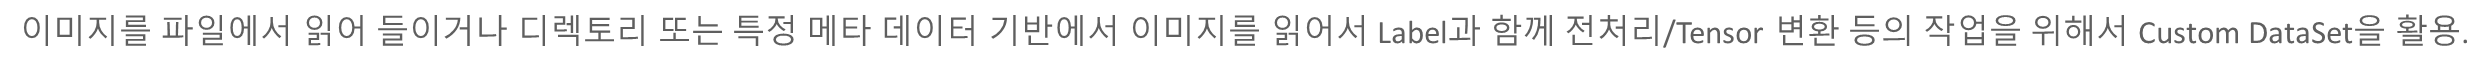
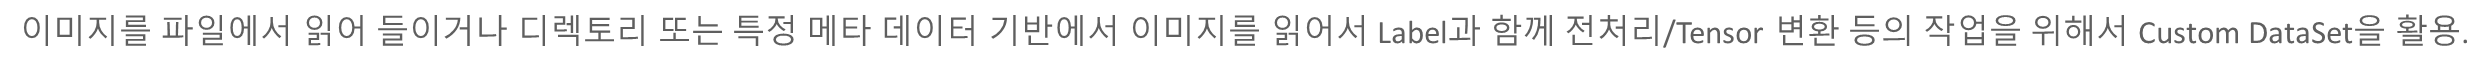
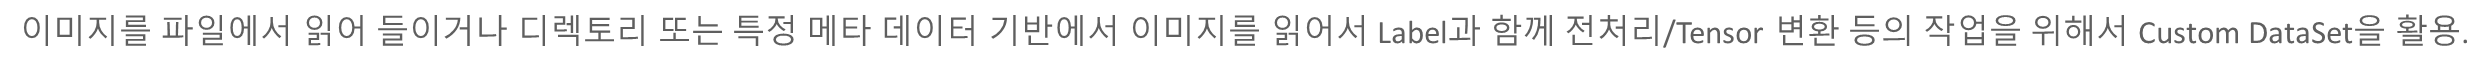
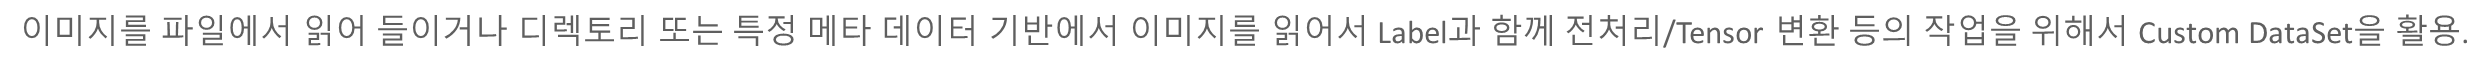

In [ ]:
import torch
from torch.utils.data import Dataset

from PIL import Image

class CnD_Dataset(Dataset):
    # 이미지 파일리스트, 타겟 파일리스트, transforms 등 이미지와 타겟 데이터 가공에 필요한 인자들을 입력 받음
    def __init__(self, image_paths, targets=None, transform=None):
        self.image_paths = image_paths
        self.targets = targets
        self.transform = transform
    
    # 전체 건수를 반환
    def __len__(self):
        return len(self.image_paths)
        
    # idx로 지정된 하나의 image, label을 tensor 형태로 반환
    def __getitem__(self, idx):    
        # PIL을 이용하여 이미지 로딩하고 PIL Image 객체 반환.
        pil_image = Image.open(self.image_paths[idx])
        # 보통은 transform이 None이 되는 경우는 거의 없음(Tensor 변환이라도 있음)
        image = self.transform(pil_image)

        if self.targets is not None:
            # 개별 target값을 tensor로 변환.
            target = torch.tensor(self.targets[idx])
            return image, target
        # 테스트 데이터의 경우 targets가 입력 되지 않을 수 있으므로 이를 대비. 
        else:
            return image, None


In [ ]:
# 전체 데이터 세트에서 학습과 테스트용 메타 정보 DataFrame 생성. 
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

train_image_paths = train_df['path'].to_list()
train_targets = train_df['target'].to_list()

In [ ]:
train_image_paths[0]

### torchvision의 transforms 적용
* torchvision transforms는 이미지 변환 로직에 주로 PIL을 사용. 
* Compose()는 연속적인 transforms 객체를 연결
* Resize() 이미지 크기를 변경
* ToTensor()는 이미지를 Tensor로 변환하고 0 ~ 1 사이값으로 정규화
* Normalize()는 인자로 들어온 채널별 평균, 채널별 표준 편차로 정규화 수행. tensor 변환된 데이터에 적용되어야 함. 

In [ ]:
from torchvision import transforms as T

IMG_SIZE = 224
IMG_MEANS = [0.485, 0.456, 0.406] # ImageNet 데이터세트의 이미지 채널별 평균값
IMG_STD = [0.229, 0.224, 0.225] # ImageNet 데이터세트의 이미지 채널별 표준편차값

#train_transform = T.Compose(T.ToTensor())
train_transform = T.Compose([
                            T.Resize(size=(IMG_SIZE, IMG_SIZE)),
                            T.ToTensor(), 
                            # T.Normalize(mean=IMG_MEANS, 
                            #             std=IMG_STD)
])

train_dataset = CnD_Dataset(image_paths=train_image_paths, 
                            targets=train_targets, transform=train_transform)

# indexing으로 접근 가능. __getitem__(self, idx) 호출 됨. range indexing은 안됨. 
image, target = train_dataset[0]

# 이미지는 torch.float32로, target은 torch.int64로 변환됨. 
print(image.dtype, target.dtype)
print(image.shape, target)
print(len(train_dataset))

#### train 을 다시 학습과 검증용 Dataset로 분리

In [ ]:
from sklearn.model_selection import train_test_split

IMG_SIZE = 224
IMG_MEANS = [0.485, 0.456, 0.406] # ImageNet 데이터세트의 이미지 채널별 평균값
IMG_STD = [0.229, 0.224, 0.225] # ImageNet 데이터세트의 이미지 채널별 표준편차값

# 기존 학습 DataFrame을 다시 학습과 검증 DataFrame으로 분할. 85%가 학습, 15%가 검증 
tr_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['target'], random_state=2025)

# 학습과 검증용 transform 생성
# 학습과 검증용 transform은 보통 다름(보통 학습은 augumentation이 적용되고 검증 용도는 augumentation 적용하지 않음) 
# 학습에 normalization이 적용되었으면 검증에도 동일한 normalization을 적용함. 
transform_01 = T.Compose([
                        T.Resize(size=(IMG_SIZE, IMG_SIZE)),
                        T.ToTensor(), 
                        T.Normalize(mean=IMG_MEANS, 
                                    std=IMG_STD)
])

tr_dataset = CnD_Dataset(image_paths=tr_df['path'].to_list(), 
                            targets=tr_df['target'].to_list(), transform=transform_01)
val_dataset = CnD_Dataset(image_paths=val_df['path'].to_list(), 
                            targets=val_df['target'].to_list(), transform=transform_01)

print(len(tr_dataset), len(val_dataset))
tr_image, tr_target = tr_dataset[0]
print(tr_image.shape, tr_target)

### DataLoader 적용하기
* Dataset 자체로도 iterate가 가능하지만, batch 단위로 한번에 모델로 데이터를 입력, 데이터 shuffle, 병렬 데이터 로딩, 메모리 활용등의 작업 수행을 처리하기 매우 어려움
* pytorch는 모델에 데이터를 batch 단위로 빠르고 효과적으로 전달하기 위해 DataLoader를 지원
* DataLoader의 주요 인자는
    * dataset: Loading 될 Dataset 객체
    * batch_size: 한번에 로딩 되어야 할 batch 크기
    * shuffle: train loop에서 신규 epoch 시마다 데이터를 섞을 지 여부. 학습 데이터의 경우는 True, 검증/테스트 데이터는 False
    * num_workers: 병렬로 동작할 서브 loader 프로세스 수. Batch 크기만큼의 데이터를 개별 worker들이 병렬로 로딩. 
    * pin_memory: GPU에서 Direct로 접근할(DMA) Pinned 메모리 영역에 Batch 데이터 로딩 여부. 

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

# Create data loaders
tr_loader = DataLoader(tr_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
images, targets = next(iter(tr_loader))
print(images.shape, images.dtype, targets.shape, targets.dtype)

### 모델 생성

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchinfo import summary

NUM_INPUT_CHANNELS = 3

class SimpleCNNWithBN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        #padding 1로 conv 적용 후 출력 면적 사이즈를 입력 면적 사이즈와 동일하게 유지.
        self.conv_block_1 = self.create_convbn_block(first_channels=3, middle_channels=32, last_channels=32)

        #out_channels이 64인 2개의 Conv2d. stride=1이 기본값, padding='same'은 version 1.8에서 소개됨.
        self.conv_block_2 = self.create_convbn_block(first_channels=32, middle_channels=64, last_channels=64)

        # filter갯수 128개인 Conv Layer 2개 적용 후 Max Pooling 적용.
        self.conv_block_3 = self.create_convbn_block(first_channels=64, middle_channels=128, last_channels=128)

        # GAP 및 최종 Classifier Layer
        self.classifier_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    def create_convbn_block(self, first_channels, middle_channels, last_channels):
        conv_bn_block = nn.Sequential(
            nn.Conv2d(in_channels=first_channels, out_channels=middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=middle_channels, out_channels=last_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(last_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        return conv_bn_block

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier_block(x)

        return x

def create_do_classifier_block(first_features, second_features, first_dos, second_dos, num_classes=10):
    return nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=first_dos),
            nn.Linear(in_features=first_features, out_features=second_features),
            nn.ReLU(),
            nn.Dropout(p=second_dos),
            nn.Linear(in_features=second_features, out_features=num_classes),
        )


### 모델 학습 수행
* Trainer 클래스를 이용하여 모델 학습.

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

class Trainer:
    def __init__(self, model, loss_fn, optimizer, train_loader, val_loader, scheduler=None, device=None):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        # scheduler 추가
        self.scheduler = scheduler
        self.device = device
        # 현재 learning rate 변수 추가
        self.current_lr = self.optimizer.param_groups[0]['lr']

    def train_epoch(self, epoch):
        self.model.train()

        # running 평균 loss 계산.
        accu_loss = 0.0
        running_avg_loss = 0.0
        # 정확도, 정확도 계산을 위한 전체 건수 및 누적 정확건수
        num_total = 0.0
        accu_num_correct = 0.0
        accuracy = 0.0
        # tqdm으로 실시간 training loop 진행 상황 시각화
        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch+1} [Training..]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.train_loader):
                # 반드시 to(self.device). to(device) 아님.
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # batch 반복 시 마다 누적  loss를 구하고 이를 batch 횟수로 나눠서 running 평균 loss 구함.
                accu_loss += loss.item()
                running_avg_loss = accu_loss /(batch_idx + 1)

                # accuracy metric 계산
                # outputs 출력 예측 class값과 targets값 일치 건수 구하고
                num_correct = (outputs.argmax(-1) == targets).sum().item()
                # 배치별 누적 전체 건수와 누적 전체 num_correct 건수로 accuracy 계산  
                num_total += inputs.shape[0]
                accu_num_correct += num_correct
                accuracy = accu_num_correct / num_total

                #tqdm progress_bar에 진행 상황 및 running 평균 loss와 정확도 표시
                progress_bar.update(1)
                if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:  # 20 batch 횟수마다 또는 맨 마지막 batch에서 update
                    progress_bar.set_postfix({"Loss": running_avg_loss,
                                              "Accuracy": accuracy})

        if not isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            self.scheduler.step()
            self.current_lr = self.scheduler.get_last_lr()[0]
            print("scheduler step() call")

        return running_avg_loss, accuracy

    def validate_epoch(self, epoch):
        if not self.val_loader:
            return None

        self.model.eval()

        # running 평균 loss 계산.
        accu_loss = 0.0
        running_avg_loss = 0.0
        # 정확도, 정확도 계산을 위한 전체 건수 및 누적 정확건수
        num_total = 0.0
        accu_num_correct = 0.0
        accuracy = 0.0
        
        with tqdm(total=len(self.val_loader), desc=f"Epoch {epoch+1} [Validating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)

                    outputs = self.model(inputs)

                    loss = self.loss_fn(outputs, targets)
                    # batch 반복 시 마다 누적  loss를 구하고 이를 batch 횟수로 나눠서 running 평균 loss 구함.
                    accu_loss += loss.item()
                    running_avg_loss = accu_loss /(batch_idx + 1)

                    # accuracy metric 계산
                    # outputs 출력 예측 class값과 targets값 일치 건수 구하고
                    num_correct = (outputs.argmax(-1) == targets).sum().item()
                    # 배치별 누적 전체 건수와 누적 전체 num_correct 건수로 accuracy 계산  
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    accuracy = accu_num_correct / num_total

                    #tqdm progress_bar에 진행 상황 및 running 평균 loss와 정확도 표시
                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:  # 20 batch 횟수마다 또는 맨 마지막 batch에서 update
                        progress_bar.set_postfix({"Loss": running_avg_loss,
                                                  "Accuracy":accuracy})
        # scheduler에 검증 데이터 기반에서 epoch레벨로 계산된 loss를 입력해줌.
        if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            self.scheduler.step(running_avg_loss)
            self.current_lr = self.scheduler.get_last_lr()[0]

        return running_avg_loss, accuracy

    def fit(self, epochs):
        # epoch 시마다 학습/검증 결과를 기록하는 history dict 생성. learning rate 추가
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate_epoch(epoch)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}",
                  f", Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}" if val_loss is not None else "",
                  f", Current lr:{self.current_lr:.6f}")
            # epoch 시마다 학습/검증 결과를 기록. learning rate 추가
            history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
            history['lr'].append(self.current_lr)

        return history

    # 학습이 완료된 모델을 return
    def get_trained_model(self):
        return self.model

In [ ]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

NUM_INPUT_CHANNELS = 3
# 개(target값 0)와 고양이(target값 1) 2개
NUM_CLASSES = 2

model = SimpleCNNWithBN(num_classes=NUM_CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(
            optimizer=optimizer, mode='min', factor=0.5, patience=3, threshold=0.01, min_lr=0.00001)

trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer,
       train_loader=tr_loader, val_loader=val_loader, scheduler=scheduler, device=device)
# 학습 및 평가
history = trainer.fit(30)

### Predictor 클래스로 예측하기

In [ ]:
class Predictor:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device

    def evaluate(self, loader):
        self.model.eval()
        eval_metric = 0.0
        # 정확도 계산을 위한 전체 건수 및 누적 정확건수
        num_total = 0.0
        accu_num_correct = 0.0

        with tqdm(total=len(loader), desc=f"[Evaluating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    pred = self.model(inputs)

                    # 정확도 계산을 위해 누적 전체 건수와 누적 전체 num_correct 건수 계산  
                    num_correct = (pred.argmax(-1) == targets).sum().item()
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    eval_metric = accu_num_correct / num_total

                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                        progress_bar.set_postfix({"Accuracy": eval_metric})
        
        return eval_metric

    def predict_proba(self, inputs):
        self.model.eval()
        with torch.no_grad():
            inputs = inputs.to(self.device)
            outputs = self.model(inputs)
            #예측값을 반환하므로 targets은 필요 없음.
            #targets = targets.to(self.device)
            pred_proba = F.softmax(outputs, dim=-1) #또는 dim=1

        return pred_proba

    def predict(self, inputs):
        pred_proba = self.predict_proba(inputs)
        pred_class = torch.argmax(pred_proba, dim=-1)

        return pred_class

#### Test용 Dataset와 DataLoader 생성 및 예측 평가 수행

In [ ]:
test_df = data_df[data_df['dataset']=='test']
test_image_paths = test_df['path'].to_list()
test_targets = test_df['target'].to_list()

IMG_SIZE=224
# test Dataset을 위한 transform 생성. 
# train과 test용 transform은 보통 다름(보통 train은 augumentation이 적용되고 test 용도는 augumentation 적용하지 않음) 
# train에 normalization이 적용되었으면 test에도 동일한 normalization을 적용함. 
transform_02 = T.Compose([
                        T.Resize(size=(IMG_SIZE, IMG_SIZE)),
                        T.ToTensor(), 
                        T.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
])

test_dataset = CnD_Dataset(image_paths=test_image_paths, 
                            targets=test_targets, transform=transform_02)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

images, targets = next(iter(test_loader))
print(images.shape)

In [ ]:
trained_model = trainer.get_trained_model()

predictor = Predictor(model=trained_model, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')